# 4. **ML Modeling - Price Prediction Regression Model**
---


###  **Machine Learning Regression Model for Price Prediction:**
To address the business problem, the proposed solution involves creating a robust machine learning model for predicting the resale price of used cars. This model will take into account various features such as the make, model, mileage, year of manufacture, and any other relevant factors that influence the pricing of used cars.

The model's implementation aims to empower purchasing agents with a tool that can provide a reasonable estimate of the resale value of a potential acquisition. This ensures that the company can make well-informed decisions when acquiring used cars, optimizing the balance between competitive pricing and maintaining healthy profit margins.




###  **Model Evaluation:**
####  Evaluation Metrics:

*   **Mean Absolute Error (MAE):**
    
    *   MAE represents the average absolute difference between the predicted prices and the actual prices.
    *   Business Relation: A low MAE indicates that, on average, the model's predictions are close to the true prices. This is crucial for the business, as it directly aligns with the goal of accurate price prediction, helping purchasing agents make informed decisions.
*   **Mean Squared Error (MSE):**
    
    *   MSE calculates the average squared difference between predicted and actual prices.
    *   Business Relation: MSE gives more weight to large errors. A low MSE indicates that the model is effective in minimizing significant deviations, which is important for ensuring that extreme pricing errors are minimized, contributing to more consistent and reliable predictions.
*   **R-squared (R2):**
    
    *   R2 measures the proportion of the variance in the target variable explained by the model.
    *   Business Relation: A high R2 suggests that a significant portion of the variability in used car prices is captured by the model. This is important for business success as it indicates that the model is effectively leveraging the provided features to predict prices, contributing to better decision-making.

In [16]:
#Library Imports

import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold

from sklearn.preprocessing import OneHotEncoder, RobustScaler
import category_encoders as ce
from category_encoders import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


In [17]:
#Load Preprocessed Data
cars = pd.read_csv("1. Combined Dataset.csv")
cars.head()

,Unnamed: 0,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,brand
0,0,C Class,2020,30495,Automatic,1200,Diesel,2.0,145.0,61.4,Mercedes
1,1,C Class,2020,29989,Automatic,1000,Petrol,1.5,145.0,46.3,Mercedes
2,2,C Class,2020,37899,Automatic,500,Diesel,2.0,145.0,61.4,Mercedes
3,3,C Class,2019,30399,Automatic,5000,Diesel,2.0,145.0,61.4,Mercedes
4,5,C Class,2019,29899,Automatic,4500,Diesel,2.0,145.0,61.4,Mercedes


## 4.1 Feature Selection

All columns in the dataset are potential features for the model. 
- The target variable is the price of the used car.
- The features are the remaining columns in the dataset.

In [18]:
cars.drop(cars[cars['fuelType'] == "Other"].index, inplace=True)

In [19]:
cars.drop(cars[cars['transmission'] == "Other"].index, inplace=True)

In [20]:
#Drop Unnecessary Columns
cars.drop(['Unnamed: 0'], axis=1, inplace=True)

## 4.2 Train Test Split

In [21]:
#Column Selection
X = cars.drop(['price'], axis = 1)
y = cars['price']

# Data Splitting dengan proporsi test size 80:20
xtrain, xtest, ytrain, ytest = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state= 42)

## 4.3 Columns Encoding

Encoding is a technique used in machine learning to convert categorical data into numerical format. In this project, we've aplied three methods: one-hot encoding for nominal categories, robust scaler Using the robust scaler to standardize the scale of numerical data. One-hot encoding is suitable for categories without a specific order and a limited set of unique values. Here's a breakdown of how each encoding type is applied.

- Onehot: Transmission, FuelType
- Robust: Mileage, Mpg,
- Binary: Model, Brand

In [22]:
transform = ColumnTransformer([
    ('Scaler', RobustScaler(), ['mileage', 'mpg']),
    ('OHE', OneHotEncoder(drop='first'), ['transmission', 'fuelType']),
    ('Binary Encoder', ce.BinaryEncoder(), ['model', 'brand'])
],remainder = "passthrough")

transform

ColumnTransformer(remainder='passthrough',
                  transformers=[('Scaler', RobustScaler(), ['mileage', 'mpg']),
                                ('OHE', OneHotEncoder(drop='first'),
                                 ['transmission', 'fuelType']),
                                ('Binary Encoder', BinaryEncoder(),
                                 ['model', 'brand'])])

## 4.4 Model Benchmarking

In the initial phase, we will perform modeling on the 7 selected benchmark models. The results from these benchmark models, in terms of scoring, will be based on the chosen evaluation metrics: RMSE, MAE, and MAPE. The selection of these three metrics is to compare the model's performance by examining its residuals.

THe benchmark models are:
- Linear Regression
- KNN Regressor
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor
- AdaBoost Regressor

In [23]:
# Define the algorithm

lr = LinearRegression()
knn = KNeighborsRegressor()
dt = DecisionTreeRegressor(random_state= 42)
rf = RandomForestRegressor(random_state= 42)
ada = AdaBoostRegressor(random_state= 42)
xgb = XGBRegressor(random_state= 42)
gbr = GradientBoostingRegressor(random_state= 42)

models = [lr, knn, dt, rf, ada, xgb, gbr]

score_rmse = []
nilai_mean_rmse = []
nilai_std_rmse = []

score_mae = []
nilai_mean_mae = []
nilai_std_mae = []

score_mape = []
nilai_mean_mape = []
nilai_std_mape = []

score_r2 = []
nilai_mean_r2 = []
nilai_std_r2 = []

# Finding the best algorithm based on each metrics

for i in models:
    
    crossval = KFold(n_splits=5, shuffle=True, random_state=42)

    estimator = Pipeline([
        ('preprocessing', transform),
        ('model', i)
    ])

    # RMSE
    model_cv_rmse = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_root_mean_squared_error', 
        error_score='raise'
        )

    print(model_cv_rmse, i)

    score_rmse.append(model_cv_rmse)
    nilai_mean_rmse.append(model_cv_rmse.mean())
    nilai_std_rmse.append(model_cv_rmse.std())

    # MAE
    model_cv_mae = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_mean_absolute_error', 
        error_score='raise'
        )

    print(model_cv_mae, i)

    score_mae.append(model_cv_mae)
    nilai_mean_mae.append(model_cv_mae.mean())
    nilai_std_mae.append(model_cv_mae.std())

    # MAPE
    model_cv_mape = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='neg_mean_absolute_percentage_error', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_mape.append(model_cv_mape)
    nilai_mean_mape.append(model_cv_mape.mean())
    nilai_std_mape.append(model_cv_mape.std())
    
    
    #R2 Score
    model_cv_r2 = cross_val_score(
        estimator, 
        xtrain, 
        ytrain, 
        cv=crossval, 
        scoring='r2', 
        error_score='raise'
        )

    print(model_cv_mape, i)

    score_r2.append(model_cv_r2)
    nilai_mean_r2.append(model_cv_r2.mean())
    nilai_std_r2.append(model_cv_r2.std())

[-4438.75429557 -4573.71477829 -4721.18650603 -4558.8328183
 -4520.62547294] LinearRegression()
[-2913.51355007 -2882.87594481 -2948.61358525 -2896.02983346
 -2829.16771329] LinearRegression()
[-0.21046663 -0.21931331 -0.20698382 -0.20916555 -0.20963944] LinearRegression()
[-0.21046663 -0.21931331 -0.20698382 -0.20916555 -0.20963944] LinearRegression()
[-2169.45845981 -2440.42282461 -2727.34072313 -2283.96570948
 -2309.85206088] KNeighborsRegressor()
[-1353.53429684 -1396.84034617 -1407.30674167 -1371.44500216
 -1383.0006924 ] KNeighborsRegressor()
[-0.08029137 -0.08358705 -0.08064046 -0.08139747 -0.08278948] KNeighborsRegressor()
[-0.08029137 -0.08358705 -0.08064046 -0.08139747 -0.08278948] KNeighborsRegressor()
[-2860.42709662 -2489.84034128 -2871.14198963 -2375.99219538
 -2547.82743283] DecisionTreeRegressor(random_state=42)
[-1525.37651233 -1511.728104   -1512.90488677 -1472.86082009
 -1498.20815014] DecisionTreeRegressor(random_state=42)
[-0.09008713 -0.09161542 -0.08847954 -0.088

In [24]:
pd.DataFrame({
    'Model': ['Linear Regression', 'KNN Regressor', 'DecisionTree Regressor',
              'RandomForest Regressor', 'AdaBoost Regressor', 'XGBoost Regressor', 'GradientBoosting Regressor'],
    'Mean_RMSE': nilai_mean_rmse,
    'Std_RMSE': nilai_std_rmse,
    'Mean_MAE': nilai_mean_mae,
    'Std_MAE': nilai_std_mae,
    'Mean_MAPE': nilai_mean_mape,
    'Std_MAPE': nilai_std_mape,
    'Mean_R2' : nilai_mean_r2,
    'Std_R2' : nilai_std_r2
}).sort_values('Mean_MAPE',ascending = False)

,Model,Mean_RMSE,Std_RMSE,Mean_MAE,Std_MAE,Mean_MAPE,Std_MAPE,Mean_R2,Std_R2
3,RandomForest Regressor,-2013.187315,145.070270,-1219.621505,14.724906,-0.073352,0.000973,0.958507,0.005752
5,XGBoost Regressor,-2012.267137,119.134299,-1290.386195,20.371498,-0.078357,0.001394,0.958595,0.004651
1,KNN Regressor,-2386.207956,191.088912,-1382.425416,18.881037,-0.081741,0.001260,0.941616,0.009101
2,DecisionTree Regressor,-2629.045811,201.076393,-1504.215695,17.882602,-0.090007,0.001189,0.929148,0.010481
6,GradientBoosting Regressor,-3002.673453,67.507349,-2025.381509,34.184005,-0.125234,0.003363,0.908030,0.003083
0,Linear Regression,-4562.622774,92.072826,-2894.040125,39.228827,-0.211114,0.004259,0.787591,0.008045
4,AdaBoost Regressor,-6633.883285,481.047805,-5568.587557,442.368769,-0.484091,0.046883,0.548184,0.072248


> From the benchmarked model, we will select the top 3 models with the best performance to be further tuned and optimized.

## 4.5 Benchmarked Model Tuning & Evaluation

From the benchmarked model, we will select the top 3 models with the best performance to be further tuned and optimized. The tuning process will be done using the GridSearchCV method. The evaluation of the tuned model will be based on the same evaluation metrics as the benchmarked model.

In [40]:
# Benchmarking top 3 Best Model

rf = RandomForestRegressor(random_state= 42)
xgb = XGBRegressor(random_state= 42)
dt = DecisionTreeRegressor(random_state= 42)

models = [rf, xgb, dt]

score_rmse = []
score_mae = []
score_mape = []
score_r2 = []

# Finding the best algorithm based on each metrics

for i in models:
    model = Pipeline([
        ('preprocessing', transform),
        ('model', i)
    ])
    
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    
    score_rmse.append(np.sqrt(mean_squared_error(ytest, y_pred)))
    score_mae.append(mean_absolute_error(ytest, y_pred))
    score_mape.append(mean_absolute_percentage_error(ytest, y_pred))
    score_r2.append(r2_score(ytest, y_pred))
    
# Model Evaluation dataframe     
score_before_tuning = pd.DataFrame({'RMSE': score_rmse, 'MAE': score_mae, 'MAPE': score_mape, 'R2': score_r2}, index=['Random Forest', 'XGBoost', 'Decission Tree'])
score_before_tuning

,RMSE,MAE,MAPE,R2
Random Forest,2147.582460,1180.189002,0.071134,0.954890
XGBoost,2039.582079,1269.665987,0.077230,0.959313
Decission Tree,2850.889548,1535.581556,0.091430,0.920505


> ###  Random Forest are found to be Best Model before Tuning, with **R2 of 95.4%** and **MAPE of 7.1%**

### 4.5.1 Random Forest Hyperparameter Tuning

In [25]:
param_grid = {
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_depth': [None, 10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor
rf = RandomForestRegressor(random_state=42)

# Create a pipeline with data preprocessing and Random Forest model
pipe_rf = Pipeline([
    ('prep', transform),
    ('model', rf)
])

# Hyperparameter tuning with GridSearchCV
grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    cv=5,
    scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'r2'],
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

In [26]:
#Fit the model from the best parameter
grid_rf.fit(xtrain, ytrain)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/Dwika/My Projects/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20, 30],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [10, 50, 100, 200]},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error', 'r2'],
             verbose=1)

In [27]:
#Display the best parameter and score
pd.DataFrame(grid_rf.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,param_model__n_estimators,params,split0_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
79,39.508163,0.465258,0.966493,0.101920,20,1,5,200,"{'model__max_depth': 20, 'model__min_samples_l...",-2285.027756,...,0.000762,1,0.945240,0.965337,0.961916,0.957294,0.964717,0.958901,0.007397,1
78,20.152166,0.510093,0.465435,0.013867,20,1,5,100,"{'model__max_depth': 20, 'model__min_samples_l...",-2289.932951,...,0.000741,2,0.945004,0.965005,0.961874,0.957535,0.964656,0.958815,0.007405,2
7,39.259313,1.310621,0.968517,0.037996,None,1,5,200,"{'model__max_depth': None, 'model__min_samples...",-2293.522228,...,0.000748,9,0.944832,0.964962,0.961286,0.956801,0.964462,0.958469,0.007413,3
115,44.254317,0.537434,1.132316,0.101657,30,1,5,200,"{'model__max_depth': 30, 'model__min_samples_l...",-2294.729935,...,0.000753,8,0.944773,0.964984,0.961250,0.956840,0.964442,0.958458,0.007431,4
77,10.408419,0.154108,0.290577,0.028100,20,1,5,50,"{'model__max_depth': 20, 'model__min_samples_l...",-2318.915029,...,0.000750,3,0.943603,0.964692,0.961751,0.957228,0.964309,0.958317,0.007823,8


In [28]:
# Best parameter for Random Forest
print('Random Forest (by GridSearchCV')
print('Best_score:', grid_rf.best_score_)
print('Best_params:', grid_rf.best_params_)

Random Forest (by GridSearchCV
Best_score: -1998.8011638904554
Best_params: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 200}


In [29]:
# Model Random Forest
model = {'RF': RandomForestRegressor(random_state= 42)}

# Define model terhadap estimator terbaik
rf_tuning = grid_rf.best_estimator_

# Fitting model
rf_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_rf_tuning = rf_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_rf_tuning = np.sqrt(mean_squared_error(ytest, y_pred_rf_tuning))
mae_rf_tuning = mean_absolute_error(ytest, y_pred_rf_tuning)
mape_rf_tuning = mean_absolute_percentage_error(ytest, y_pred_rf_tuning)
r2_rf_tuning = r2_score(ytest, y_pred_rf_tuning)

score_after_tuning_rf = pd.DataFrame({'RMSE': rmse_rf_tuning, 'MAE': mae_rf_tuning, 'MAPE': mape_rf_tuning, 'R2': r2_rf_tuning}, index=model.keys())
score_after_tuning_rf

,RMSE,MAE,MAPE,R2
RF,1800.686625,1148.057476,0.071081,0.966158


### 4.5.2 XGBOOST Hyperparameter Tuning

In [31]:
param_grid_xgb = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [3, 6, 9],  # XGBoost uses maximum depth instead of None
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

# Create an XGBoost Regressor
xgb = XGBRegressor(random_state=42)

# Create a pipeline with data preprocessing and XGBoost model
pipe_xgb = Pipeline([
    ('prep', transform),
    ('model', xgb)
])

# Hyperparameter tuning with GridSearchCV
grid_xgb = GridSearchCV(
    estimator=pipe_xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring={
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
        'r2': 'r2'
    },
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)
grid_xgb.fit(xtrain, ytrain)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_b...
                         'model__learning_rate': [0.01, 0.1, 0.2],
                         'model__max_depth': [3, 6, 9],
                         'model__n_estimators': [50, 100, 200],
                         'model__subsample': [0.8, 1.0]},
             refit='neg_root_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [32]:
pd.DataFrame(grid_xgb.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
34,2.444642,0.041817,0.233976,0.025933,0.8,0.1,9,200,0.8,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.000575,2,0.952058,0.969492,0.965382,0.960860,0.965859,0.962730,0.005999,1
35,2.194974,0.080343,0.202679,0.032044,0.8,0.1,9,200,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.000677,1,0.952006,0.969126,0.965555,0.960669,0.966240,0.962719,0.006008,2
53,2.504093,0.115195,0.290283,0.051523,0.8,0.2,9,200,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.000811,3,0.951908,0.968444,0.965053,0.960795,0.965104,0.962261,0.005717,3
51,1.680328,0.170267,0.188770,0.060600,0.8,0.2,9,100,1.0,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.000723,8,0.951392,0.968350,0.964645,0.960554,0.965166,0.962021,0.005864,5
50,1.791119,0.096379,0.185199,0.050045,0.8,0.2,9,100,0.8,"{'model__colsample_bytree': 0.8, 'model__learn...",...,0.000548,10,0.952845,0.967918,0.964470,0.959532,0.965370,0.962027,0.005336,4


In [33]:
print('XGBoost (by GridSearchCV')
print('Best_score:', grid_xgb.best_score_)
print('Best_params:', grid_xgb.best_params_)

XGBoost (by GridSearchCV
Best_score: -1904.8823202545614
Best_params: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 200, 'model__subsample': 0.8}


In [52]:
# Model XGBoost Regressor
model = {'XGB': XGBRegressor(random_state= 42)}

# Define model terhadap estimator terbaik
xgb_tuning = grid_xgb.best_estimator_

# Fitting model
xgb_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_xgb_tuning = xgb_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_xgb_tuning = np.sqrt(mean_squared_error(ytest, y_pred_xgb_tuning))
mae_xgb_tuning = mean_absolute_error(ytest, y_pred_xgb_tuning)
mape_xgb_tuning = mean_absolute_percentage_error(ytest, y_pred_xgb_tuning)
r2_xgb_tuning = r2_score(ytest, y_pred_xgb_tuning)

score_after_tuning_xgb = pd.DataFrame({'RMSE': rmse_xgb_tuning, 'MAE': mae_xgb_tuning, 'MAPE': mape_xgb_tuning, 'R2': r2_xgb_tuning}, index=model.keys())
score_after_tuning_xgb

,RMSE,MAE,MAPE,R2
XGB,1755.302,1134.334975,0.07027,0.967843


### 4.5.3 Decision Tree Hyperparameter Tuning

In [35]:
param_grid_dt = {
    'model__max_depth': [None, 3, 6, 9],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Create a Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=2023)

# Create a pipeline with data preprocessing and Decision Tree model
pipe_dt = Pipeline([
    ('prep', transform),
    ('model', dt)
])

# Hyperparameter tuning with GridSearchCV
grid_dt = GridSearchCV(
    estimator=pipe_dt,
    param_grid=param_grid_dt,
    cv=5,
    scoring={
        'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
        'neg_mean_absolute_error': 'neg_mean_absolute_error',
        'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
        'r2': 'r2'
    },
    refit='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1,
)

# Fit the model
grid_dt.fit(xtrain, ytrain)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('Scaler',
                                                                         RobustScaler(),
                                                                         ['mileage',
                                                                          'mpg']),
                                                                        ('OHE',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['transmission',
                                                                          'fuelType']),
                                                                        ('Binary '
                                                                         'Encoder',
                                                                         BinaryEncoder(),
                                                                         ['model',
                                                                          'brand'])])),
                                       ('model',
                                        DecisionTreeRegressor(random_state=2023))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 3, 6, 9],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10]},
             refit='neg_root_mean_squared_error',
             scoring={'neg_mean_absolute_error': 'neg_mean_absolute_error',
                      'neg_mean_absolute_percentage_error': 'neg_mean_absolute_percentage_error',
                      'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
                      'r2': 'r2'},
             verbose=1)

In [54]:
pd.DataFrame(grid_dt.cv_results_).sort_values(\
    by=['rank_test_neg_root_mean_squared_error','rank_test_neg_mean_absolute_error', 'rank_test_neg_mean_absolute_percentage_error', 'rank_test_r2']).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__min_samples_leaf,param_model__min_samples_split,params,split0_test_neg_root_mean_squared_error,split1_test_neg_root_mean_squared_error,...,std_test_neg_mean_absolute_percentage_error,rank_test_neg_mean_absolute_percentage_error,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,mean_test_r2,std_test_r2,rank_test_r2
6,0.367642,0.038377,0.025379,0.009195,None,4,2,"{'model__max_depth': None, 'model__min_samples...",-2745.790897,-2227.931928,...,0.000765,3,0.920929,0.949657,0.948610,0.938691,0.949221,0.941421,0.011025,1
7,0.346278,0.033174,0.024467,0.006848,None,4,5,"{'model__max_depth': None, 'model__min_samples...",-2745.790897,-2227.931928,...,0.000765,3,0.920929,0.949657,0.948610,0.938691,0.949221,0.941421,0.011025,1
8,0.378674,0.023724,0.018423,0.003882,None,4,10,"{'model__max_depth': None, 'model__min_samples...",-2752.534762,-2277.821308,...,0.000856,2,0.920540,0.947377,0.948574,0.940516,0.950028,0.941407,0.010932,3
5,0.344712,0.020966,0.026933,0.005505,None,2,10,"{'model__max_depth': None, 'model__min_samples...",-2760.402932,-2241.914760,...,0.001013,1,0.920085,0.949023,0.950392,0.934722,0.949579,0.940760,0.011856,4
4,0.293935,0.010270,0.021260,0.002257,None,2,5,"{'model__max_depth': None, 'model__min_samples...",-2831.072805,-2313.459578,...,0.001160,6,0.915941,0.945718,0.949212,0.936074,0.945767,0.938542,0.012120,5


In [38]:
print('Decission Tree (by GridSearchCV')
print('Best_score:', grid_dt.best_score_)
print('Best_params:', grid_dt.best_params_)

Decission Tree (by GridSearchCV
Best_score: -2385.4964531870583
Best_params: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}


In [39]:
# Model DT Regressor
model = {'DT': DecisionTreeRegressor(random_state= 2023)}

# Define model terhadap estimator terbaik
dt_tuning = grid_dt.best_estimator_

# Fitting model
dt_tuning.fit(xtrain, ytrain)

# Predict test set
y_pred_dt_tuning = dt_tuning.predict(xtest)

# Simpan nilai metrics RMSE, MAE & MAPE setelah tuning
rmse_dt_tuning = np.sqrt(mean_squared_error(ytest, y_pred_dt_tuning))
mae_dt_tuning = mean_absolute_error(ytest, y_pred_dt_tuning)
mape_dt_tuning = mean_absolute_percentage_error(ytest, y_pred_dt_tuning)
r2_dt_tuning = r2_score(ytest, y_pred_dt_tuning)

score_after_tuning_dt = pd.DataFrame({'RMSE': rmse_dt_tuning, 'MAE': mae_dt_tuning, 'MAPE': mape_dt_tuning, 'R2': r2_dt_tuning}, index=model.keys())
score_after_tuning_dt

,RMSE,MAE,MAPE,R2
DT,2158.12974,1339.839839,0.082066,0.951389


---

### 4.5.4 Model Evaluation

In [53]:
# Model Evaluation dataframe
# Create dataframe from tuned models and rank them
score_after_tuning = pd.concat([score_after_tuning_rf, score_after_tuning_xgb, score_after_tuning_dt]).sort_values('R2', ascending=False)
score_after_tuning

,RMSE,MAE,MAPE,R2
XGB,1755.302000,1134.334975,0.070270,0.967843
RF,1800.686625,1148.057476,0.071081,0.966158
DT,2158.129740,1339.839839,0.082066,0.951389


> ### XGBOOST are found to be Best Model after Tuning

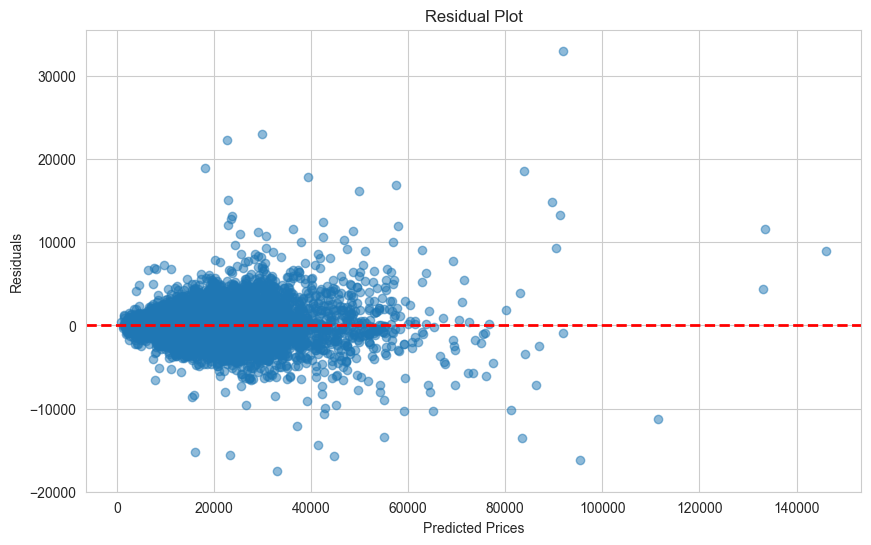

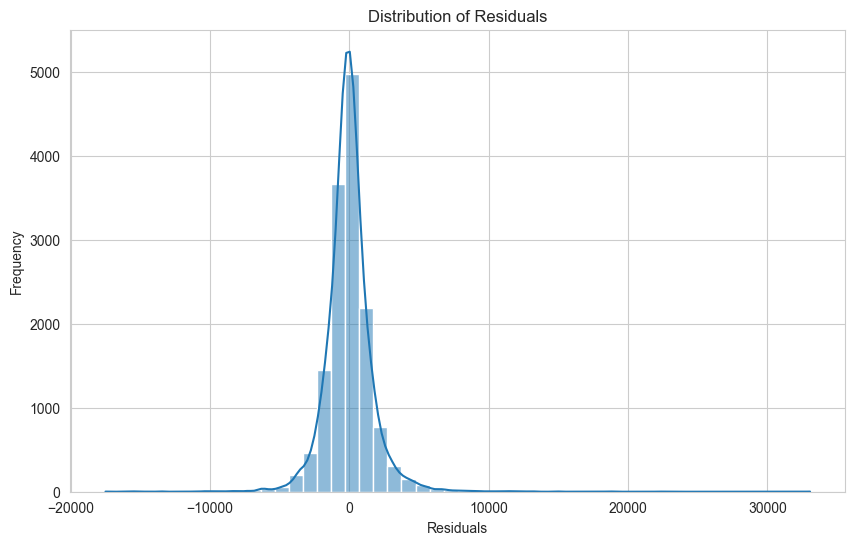

In [90]:
#Residual Plot from XGBoost Tuned Model
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate residuals
residuals = ytest - y_pred_xgb_tuning

# Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb_tuning, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Prices')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)  # Horizontal line at y=0 for reference
plt.show()

# Distribution of Residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


- From the residual plots, we can see that the residuals are randomly distributed around the centerline with no obvious pattern. This indicates that the model is able to capture the underlying trend of the data and make good predictions.

- The distribution of the residuals is also approximately normal, with a mean of 0. This indicates that the model's predictions are unbiased, as the residuals are centered around zero.

## 4.6 Prediction output simulation

xgboost model is used to predict the price of the used car. The prediction is based on the input of the user. 

The user will be asked to input the following information:


In [42]:
#Sample data test simulation
sample = cars.sample(200)
sample.head()

,model,year,price,transmission,mileage,fuelType,engineSize,tax,mpg,brand
39118,A3,2018,21995,Semi-Auto,15696,Petrol,1.5,145.0,42.2,Audi
35691,A1,2017,13995,Manual,12148,Petrol,1.0,145.0,67.3,Audi
20100,Kuga,2015,12498,Manual,60151,Diesel,2.0,145.0,54.3,Ford
71201,Arteon,2019,25897,Semi-Auto,6777,Petrol,2.0,145.0,47.1,Volkswagen
41713,Q3,2016,19990,Semi-Auto,29241,Petrol,2.0,200.0,42.2,Audi


We're taking random samples from initial data and use it as input for the model. The output of the model is the predicted price of the used car.

In [71]:
#Sample prediction simulation

#Define xgboost from best parameter
xgb_tuning = grid_xgb.best_estimator_

# # Predict price from sample data
sample_pred = xgb_tuning.predict(sample.drop('price', axis=1))


#Print resulting dataframe
result_df = pd.DataFrame({
    'Brand': sample['brand'],
    'Model': sample['model'],
    'Year': sample['year'],
    'Predicted Price': sample_pred,
    'Actual Price': sample['price'],
    'Difference': sample_pred - sample['price'],
    'Error (%)': round(((sample_pred - sample['price']) / sample['price']) * 100, 2)
})
result_df

,Brand,Model,Year,Predicted Price,Actual Price,Difference,Error (%)
39118,Audi,A3,2018,21424.277344,21995,-570.722656,-2.59
35691,Audi,A1,2017,13081.363281,13995,-913.636719,-6.53
20100,Ford,Kuga,2015,11288.735352,12498,-1209.264648,-9.68
71201,Volkswagen,Arteon,2019,26764.816406,25897,867.816406,3.35
41713,Audi,Q3,2016,19862.560547,19990,-127.439453,-0.64
...,...,...,...,...,...,...,...
62135,Volkswagen,Golf,2016,10809.298828,10699,110.298828,1.03
11723,Mercedes,A Class,2019,23849.164062,22590,1259.164062,5.57
70047,Volkswagen,Up,2020,10481.405273,10999,-517.594727,-4.71
49131,Skoda,Octavia,2019,17204.562500,17995,-790.437500,-4.39


In [82]:
result_df.groupby(['Brand'])['Error (%)'].mean().sort_values(ascending=False)

Brand
Skoda         7.241250
Toyota        4.202667
Ford          0.963333
Mercedes      0.832143
Volkswagen   -0.666222
Audi         -1.788929
Name: Error (%), dtype: float64

The model shows better prediction results on certain brands. For example, 
- the model shows <1% error results on Volkswagen, Audi, and Mercedes-Benz. 
- The model shows worse prediction results (>1%) on Skoda, Toyota, and Audi.

In [78]:
print(f" Total overpriced result: {result_df[result_df['Error (%)'] > 0][['Difference']].sum()} $")
print(f" Total overpriced result: {result_df[result_df['Error (%)'] < 0][['Difference']].sum()} $")
print(f" Total overpriced result: {result_df[['Difference']].sum()} $")


 Total overpriced result: Difference    93541.716797
dtype: float64 $
 Total overpriced result: Difference   -103834.436035
dtype: float64 $
 Total overpriced result: Difference   -10292.719238
dtype: float64 $


---

## 4.7 Conclusion



XGBOOST are found to be Best Model after Tuning

In [85]:
#XGboost tuning scores
score_after_tuning_xgb

,RMSE,MAE,MAPE,R2
XGB,1755.302,1134.334975,0.07027,0.967843


- From the 7 model we've tested, XGBoost Regressor is found to be the best model with the lowest MAPE of 7% and R2 of 96.8%.
- With up to 96,8% accuracy from model prediction output, the company can make well-informed decisions when acquiring used cars, optimizing the balance between competitive pricing and maintaining healthy profit margins.
- The model shows better prediction results on certain brands. For example, the model shows <1% error results on Volkswagen, Audi, and Mercedes-Benz. The model shows worse prediction results (>1%) on Skoda, Toyota, and Audi.


## 4.8 Recommendations

- The model is better suited to predict the price of used cars from certain brands such as Volkswagen, Audi, and Mercedes-Benz.
- Expand the dataset to include more data points for other brands, especially those where the model currently exhibits higher prediction errors (e.g., Skoda, Toyota, Ford).
- To future optimize the model, we can add more features such as the condition of the car, the number of previous owners, and the number of accidents.

---

In [84]:
#Save the model
# import pickle
# pickle.dump(xgb_tuning, open('model_xgb_tuning.pkl', 'wb'))
